# Travel Insurance Claim Prediction

In [1159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno
import seaborn as sns

import scipy.stats as ss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [1160]:
df_train = pd.read_csv('C:\\Users\\Priyanka\\Desktop\\python2\\Hackathon-1\\Data\\Train_file.csv')

## Data Insight Report

In [1161]:
df_train.shape

(62288, 12)

In [1162]:
df_train.head()

,ID,Age,Agency,Agency Type,Commision (in value),Destination,Distribution Channel,Duration,Gender,Net Sales,Product Name,Claim
0,45341,28,C2B,Airlines,28.13,SINGAPORE,Online,34,F,112.5,Silver Plan,1
1,12958,37,JZI,Airlines,12.95,PHILIPPINES,Online,53,F,37.0,Basic Plan,0
2,18233,27,EPX,Travel Agency,0.00,UNITED STATES,Online,28,NaN,13.0,Cancellation Plan,0
3,31742,36,EPX,Travel Agency,0.00,SAUDI ARABIA,Online,1,NaN,34.0,Cancellation Plan,0
4,14381,26,CWT,Travel Agency,23.76,THAILAND,Online,33,NaN,39.6,Rental Vehicle Excess Insurance,0


In [1163]:
df_train['Agency Type'].value_counts()

Travel Agency    40816
Airlines         21472
Name: Agency Type, dtype: int64

In [1164]:
df_train.columns.to_list()

['ID',
 'Age',
 'Agency',
 'Agency Type',
 'Commision (in value)',
 'Destination',
 'Distribution Channel',
 'Duration',
 'Gender',
 'Net Sales',
 'Product Name',
 'Claim']

In [1165]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62288 entries, 0 to 62287
Data columns (total 12 columns):
ID                      62288 non-null int64
Age                     62288 non-null int64
Agency                  62288 non-null object
Agency Type             62288 non-null object
Commision (in value)    62288 non-null float64
Destination             62288 non-null object
Distribution Channel    62288 non-null object
Duration                62288 non-null int64
Gender                  22713 non-null object
Net Sales               62288 non-null float64
Product Name            62288 non-null object
Claim                   62288 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 5.7+ MB


In [1166]:
# Define Utiliy Functions
def data_insights_report(data=pd.DataFrame()):
    report = pd.DataFrame()
    report['Columns'] = data.columns
    report['Data_Types'] = data.dtypes.values
    report['Unique_Count'] = data.nunique().values
    report['NAN_Count'] = data.isna().sum().values

    tempdf = data.describe().apply(lambda x: round(x,2), axis=1).T
    pd.merge(report,tempdf.reset_index().rename(columns={'index':'Columns'}), on='Columns')

    return report.join(tempdf, on='Columns')
data_insights_report(df_train) # This report gives as view of the data, its metrics and basic actionable Insights

,Columns,Data_Types,Unique_Count,NAN_Count,count,mean,std,min,25%,50%,75%,max
0,ID,int64,50756,0,62288.0,32844.95,18065.42,0.0,17579.0,33446.50,48532.25,63323.00
1,Age,int64,89,0,62288.0,39.67,14.01,0.0,33.0,36.00,43.00,118.00
2,Agency,object,16,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Agency Type,object,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Commision (in value),float64,940,0,62288.0,12.83,23.50,0.0,0.0,1.88,14.44,262.76
5,Destination,object,102,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Distribution Channel,object,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Duration,int64,443,0,62288.0,60.96,114.33,-2.0,10.0,25.00,59.00,4881.00
8,Gender,object,2,39575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Net Sales,float64,1037,0,62288.0,50.72,63.17,-389.0,20.0,29.70,58.00,682.00


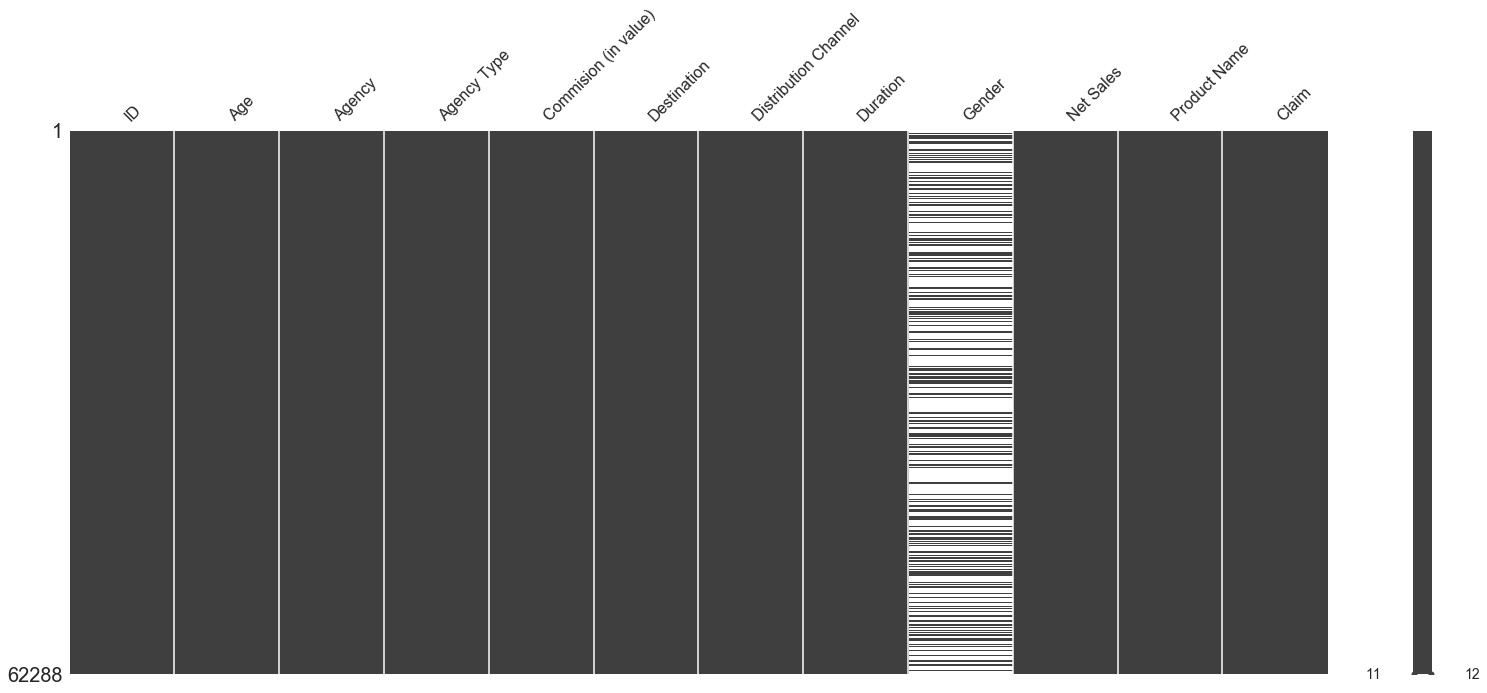

In [1167]:
missingno.matrix(df_train)

In [1168]:
#percentage of null values
temp_df = df_train.isnull().sum().reset_index()
temp_df['Percentage'] = (temp_df[0]/len(df_train))*100
temp_df.columns = ['Column Name', 'Number of null values', 'Null values in percentage']
print(f"The length of dataset is \t {len(df_train)}")
temp_df

The length of dataset is 	 62288


,Column Name,Number of null values,Null values in percentage
0,ID,0,0.000000
1,Age,0,0.000000
2,Agency,0,0.000000
3,Agency Type,0,0.000000
4,Commision (in value),0,0.000000
5,Destination,0,0.000000
6,Distribution Channel,0,0.000000
7,Duration,0,0.000000
8,Gender,39575,63.535512
9,Net Sales,0,0.000000


## Pre Processing the Data

In [1169]:
df_train.dtypes  # understand the features type

ID                        int64
Age                       int64
Agency                   object
Agency Type              object
Commision (in value)    float64
Destination              object
Distribution Channel     object
Duration                  int64
Gender                   object
Net Sales               float64
Product Name             object
Claim                     int64
dtype: object

In [1170]:
# to check unique values:
df_train.nunique()

ID                      50756
Age                        89
Agency                     16
Agency Type                 2
Commision (in value)      940
Destination               102
Distribution Channel        2
Duration                  443
Gender                      2
Net Sales                1037
Product Name               25
Claim                       2
dtype: int64

In [1171]:
categorical = df_train.select_dtypes(include = 'object')
print(len(categorical.columns))

6


In [1172]:
categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62288 entries, 0 to 62287
Data columns (total 6 columns):
Agency                  62288 non-null object
Agency Type             62288 non-null object
Destination             62288 non-null object
Distribution Channel    62288 non-null object
Gender                  22713 non-null object
Product Name            62288 non-null object
dtypes: object(6)
memory usage: 2.9+ MB


In [1173]:
numerical = df_train.select_dtypes(include = ['float64', 'int64'])
print(len(numerical.columns))

6


In [1174]:
numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62288 entries, 0 to 62287
Data columns (total 6 columns):
ID                      62288 non-null int64
Age                     62288 non-null int64
Commision (in value)    62288 non-null float64
Duration                62288 non-null int64
Net Sales               62288 non-null float64
Claim                   62288 non-null int64
dtypes: float64(2), int64(4)
memory usage: 2.9 MB


In [1175]:
categorical.head()

,Agency,Agency Type,Destination,Distribution Channel,Gender,Product Name
0,C2B,Airlines,SINGAPORE,Online,F,Silver Plan
1,JZI,Airlines,PHILIPPINES,Online,F,Basic Plan
2,EPX,Travel Agency,UNITED STATES,Online,NaN,Cancellation Plan
3,EPX,Travel Agency,SAUDI ARABIA,Online,NaN,Cancellation Plan
4,CWT,Travel Agency,THAILAND,Online,NaN,Rental Vehicle Excess Insurance


In [1176]:
numerical.head()

,ID,Age,Commision (in value),Duration,Net Sales,Claim
0,45341,28,28.13,34,112.5,1
1,12958,37,12.95,53,37.0,0
2,18233,27,0.00,28,13.0,0
3,31742,36,0.00,1,34.0,0
4,14381,26,23.76,33,39.6,0


                            ID       Age  Commision (in value)  Duration  \
ID                    1.000000  0.003697              0.115840  0.037260   
Age                   0.003697  1.000000              0.080202 -0.003637   
Commision (in value)  0.115840  0.080202              1.000000  0.492882   
Duration              0.037260 -0.003637              0.492882  1.000000   
Net Sales             0.080545  0.021144              0.750256  0.606696   
Claim                 0.144786 -0.039255              0.276378  0.217081   

                      Net Sales     Claim  
ID                     0.080545  0.144786  
Age                    0.021144 -0.039255  
Commision (in value)   0.750256  0.276378  
Duration               0.606696  0.217081  
Net Sales              1.000000  0.344922  
Claim                  0.344922  1.000000  


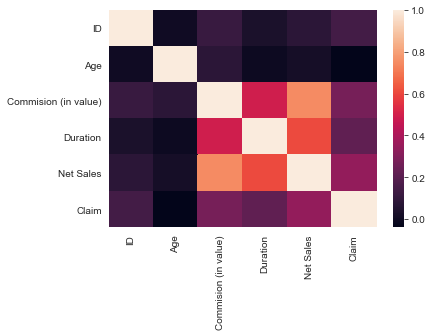

In [1177]:
# Finding Corelation
corr = df_train.corr()
print(corr)
sns.heatmap(corr, 
         xticklabels=corr.columns, 
         yticklabels=corr.columns)

## Univariate & Bivariate Analysis

### Final Outcome Column :Claim

Text(0.5, 1.0, 'Count Plot for Outcome')

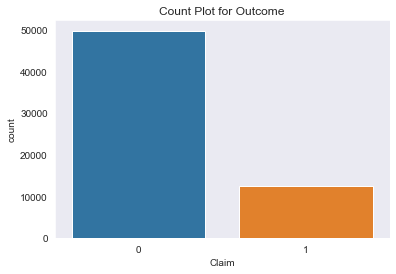

In [1178]:
# creating count plot with title using seaborn
sns.countplot(x=df_train.Claim)
plt.title("Count Plot for Outcome")

In [1179]:
# Computing the %age of claim-0 and claim-1 in the Dataset
Out1=len(df_train[df_train.Claim==1])
Out0=len(df_train[df_train.Claim==0])
Total=Out0+Out1
PC_of_1 = Out1*100/Total
PC_of_0 = Out0*100/Total
PC_of_1, PC_of_0
print("% of claim(1):",PC_of_1)
print("% of claim(0):",PC_of_0)

% of claim(1): 20.000642178268688
% of claim(0): 79.99935782173131


In [1180]:
df_train['Age'].nunique()

89

In [1181]:
df_train['Age'].unique()

array([ 28,  37,  27,  36,  26,  39,  34,  45,  32,  59,  33,  50,  67,
        55,  47,  41,  43,  35,  46,  51,  53,  22,  40,  24,  29,  38,
        79, 118,  60,  30,  49,  48,  52,  54,  16,  21,  64,  31,  56,
        44,  70,  71,  66,  19,  25,  42,  62,  23,  57,  58,  61,  63,
        77,  74,  65,  20,  73,  84,  68,  72,  69,  81,  76,  82,  17,
        87,   3,  13,  18,  14,  88,  83,  75,  80,   0,  12,   1,   4,
        78,   9,  86,   8,  15,  85,   7,  10,   5,  11,   2], dtype=int64)

In [1182]:
# ?sns.boxplot()                       for help section

## Column :Age

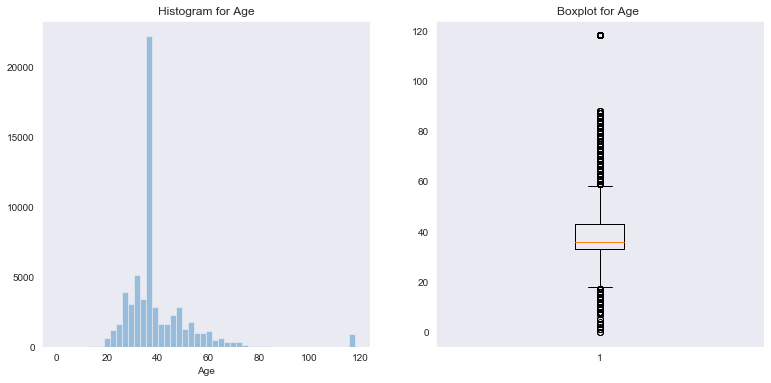

In [1183]:
# creating dist plot with Age using seaborn
plt.figure(figsize=(20, 6))
plt.subplot(1,3,1)
sns.set_style("dark")
plt.title("Histogram for Age")
sns.distplot(df_train.Age,kde=False)
plt.subplot(1,3,2)
plt.boxplot(df_train.Age)
plt.title("Boxplot for Age ")
plt.show()

## inference:
### Age starts from 0 to 118

### maximum Age lies between 30 & 50

In [1184]:
df_train['Age'].nunique()

89

In [1185]:
df_train['Age'].unique()

array([ 28,  37,  27,  36,  26,  39,  34,  45,  32,  59,  33,  50,  67,
        55,  47,  41,  43,  35,  46,  51,  53,  22,  40,  24,  29,  38,
        79, 118,  60,  30,  49,  48,  52,  54,  16,  21,  64,  31,  56,
        44,  70,  71,  66,  19,  25,  42,  62,  23,  57,  58,  61,  63,
        77,  74,  65,  20,  73,  84,  68,  72,  69,  81,  76,  82,  17,
        87,   3,  13,  18,  14,  88,  83,  75,  80,   0,  12,   1,   4,
        78,   9,  86,   8,  15,  85,   7,  10,   5,  11,   2], dtype=int64)

## Column : Duration

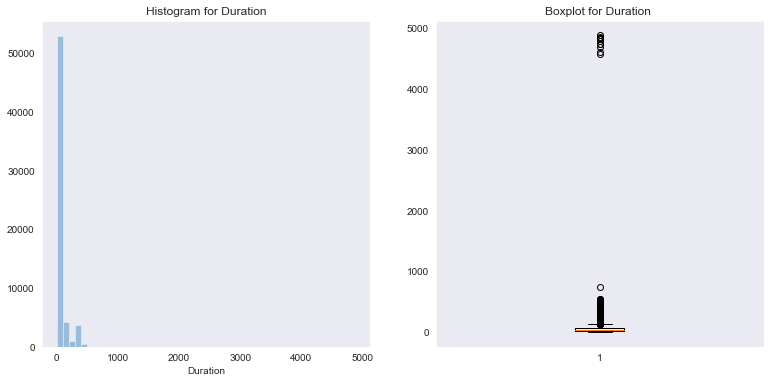

In [1186]:
#creating dist plot with Duration using seaborn
plt.figure(figsize=(20, 6))
plt.subplot(1,3,1)
sns.set_style("dark")
plt.title("Histogram for Duration")
sns.distplot(df_train.Duration,kde=False)
plt.subplot(1,3,2)
plt.boxplot(df_train.Duration)
plt.title("Boxplot for Duration ")
plt.show()

In [1187]:
df_train['Duration'].max()

4881

In [1188]:
df_train['Duration'].min()

-2

## Inference:

#### Duration is total number of days that person travelled during all his trips

#### Duration lies betwen -2 to 4881 (in days)

### Column: Commision(in value)

In [1189]:
df_train['Commision (in value)'].head(10)

0    28.13
1    12.95
2     0.00
3     0.00
4    23.76
5    59.40
6    23.76
7     9.10
8    63.21
9    63.21
Name: Commision (in value), dtype: float64

In [1190]:
pd.crosstab(index=df_train['Commision (in value)'],columns=df_train['Claim'])

Claim,0,1
Commision (in value),,
0.00,27926,2619
0.02,10,0
0.04,1,0
0.05,11,0
0.09,11,0
...,...,...
208.16,4,15
209.95,2,0
210.21,30,36


In [1191]:
df_train['Commision (in value)'].head(5)

0    28.13
1    12.95
2     0.00
3     0.00
4    23.76
Name: Commision (in value), dtype: float64

Text(0.5, 1.0, 'Boxplot for  claim by Commision in value')

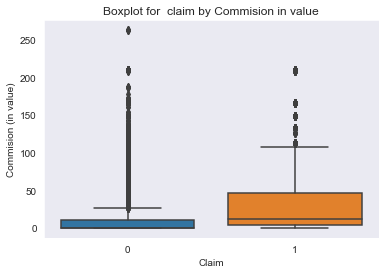

In [1192]:
# creating box plot of commision in value & claim using seaborn
plt.subplot(1,1,1)
sns.boxplot(x=df_train.Claim,y=df_train['Commision (in value)'])
plt.title("Boxplot for  claim by Commision in value")

## Inference
### Commision has outliers because some are the values which are higher & out of trend

### Column : Agency

In [1193]:
pd.crosstab(index=df_train['Agency'],columns=df_train['Claim'])

Claim,0,1
Agency,,
ADM,65,0
ART,259,12
C2B,6194,7414
CBH,85,14
CCR,164,47
CSR,62,13
CWT,6796,1160
EPX,27845,2570
JWT,600,39


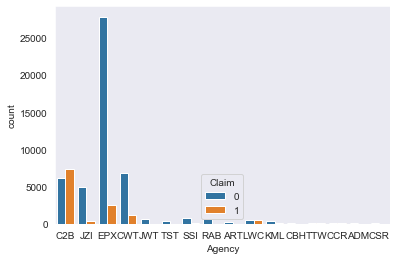

In [1194]:
sns.countplot(x=df_train['Agency'],hue=df_train['Claim'])

In [1195]:
### Column: Agency Type

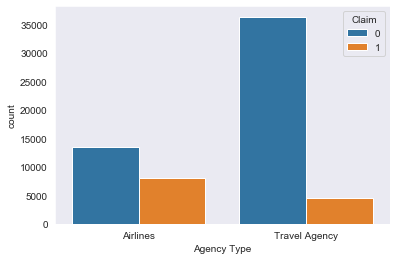

In [1196]:
sns.countplot(x=df_train['Agency Type'],hue=df_train['Claim'])

### Inference
### Agency Type: Airlines has maximum number of claims

### Column:Distribution Channel

In [1197]:
df_train['Distribution Channel'].value_counts()

Online     61172
Offline     1116
Name: Distribution Channel, dtype: int64

In [1198]:
pd.crosstab(index=df_train['Distribution Channel'],columns=df_train['Claim'])

Claim,0,1
Distribution Channel,,
Offline,874,242
Online,48956,12216


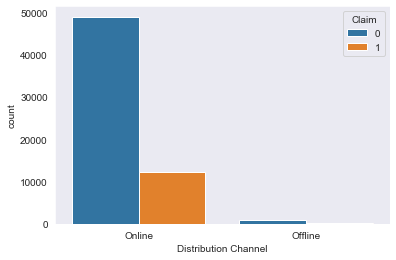

In [1199]:
sns.countplot(x=df_train['Distribution Channel'],hue=df_train['Claim'])

### Inference:
#### maximum number of travel plans has bought Online and claim are also more

## Column : Product name

In [1200]:
df_train['Product Name'].nunique()

25

C:\Users\Priyanka\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


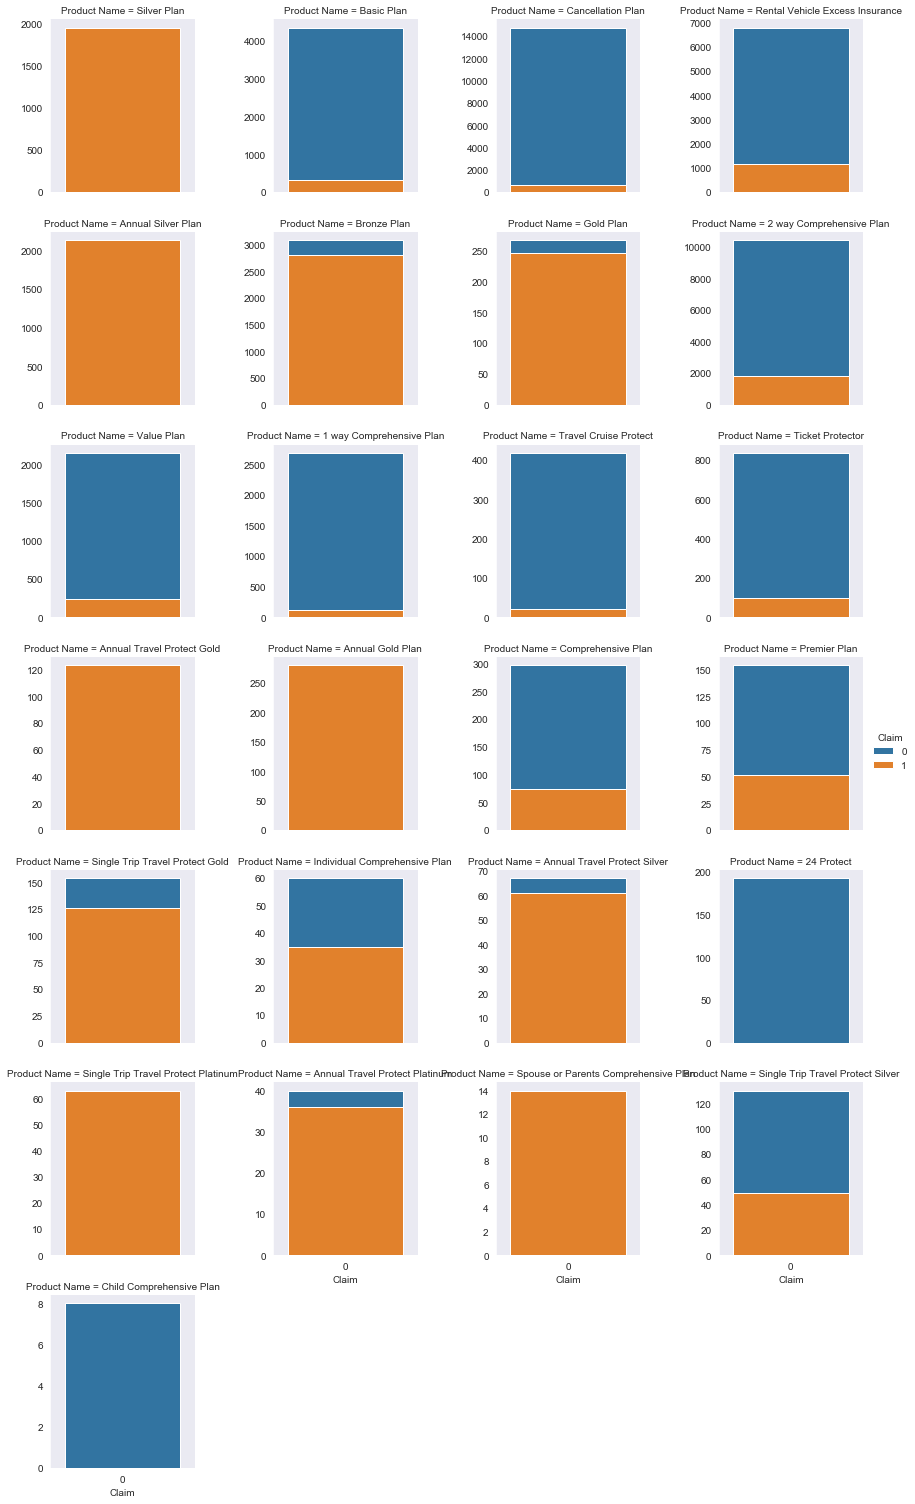

In [1201]:
g = sns.FacetGrid(df_train, col='Product Name', col_wrap=4, hue='Claim', sharey=False)
g.map(sns.countplot, 'Claim').add_legend()
#plt.suptitle('Defaulter ratio by branches', y=1.02, fontsize=15, color='blue')
plt.show()

In [1202]:
pd.crosstab(index=df_train['Product Name'],columns=df_train['Claim'])

Claim,0,1
Product Name,,
1 way Comprehensive Plan,2688,119
2 way Comprehensive Plan,10409,1845
24 Protect,193,0
Annual Gold Plan,142,280
Annual Silver Plan,1011,2132
Annual Travel Protect Gold,75,123
Annual Travel Protect Platinum,40,36
Annual Travel Protect Silver,67,61
Basic Plan,4341,324


## Column:Destination

In [1203]:
df_train['Destination'].nunique()

102

In [1204]:
pd.crosstab(index=df_train['Destination'],columns=df_train['Claim'])

Claim,0,1
Destination,,
ARGENTINA,15,12
AUSTRALIA,2940,543
AUSTRIA,81,0
AZERBAIJAN,6,0
BAHRAIN,10,0
...,...,...
UZBEKISTAN,10,0
VANUATU,3,0
VENEZUELA,4,0


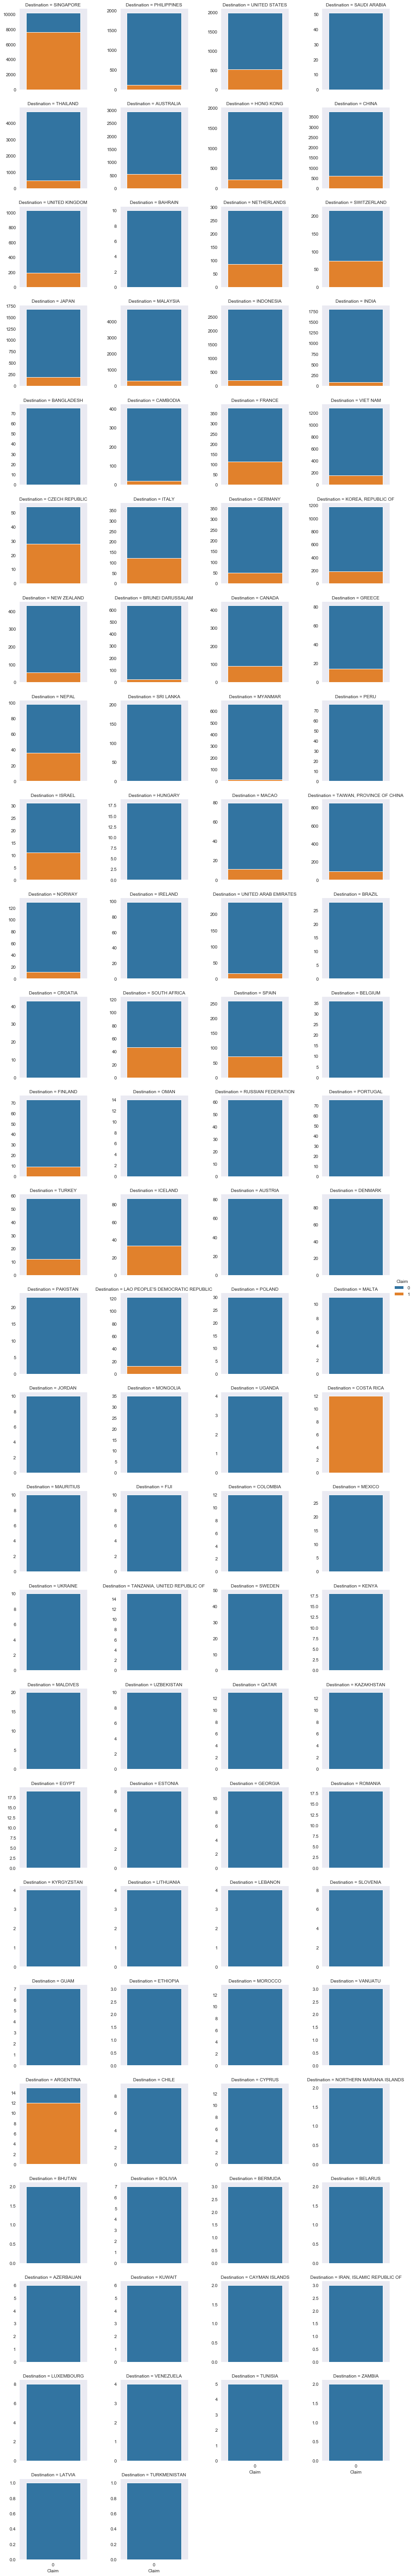

In [1205]:
g = sns.FacetGrid(df_train, col='Destination', col_wrap=4, hue='Claim', sharey=False)
g.map(sns.countplot, 'Claim').add_legend()
#plt.suptitle('Defaulter ratio by branches', y=1.02, fontsize=15, color='blue')
plt.show()

In [1206]:
df_train['Destination'].value_counts()

SINGAPORE         17796
THAILAND           5179
MALAYSIA           5073
CHINA              4346
AUSTRALIA          3483
                  ...  
ZAMBIA                2
BHUTAN                2
CAYMAN ISLANDS        2
TURKMENISTAN          1
LATVIA                1
Name: Destination, Length: 102, dtype: int64

### Column:Gender

In [1207]:
df_train['Gender'].value_counts()

F    11484
M    11229
Name: Gender, dtype: int64

In [1208]:
df_train['Gender'].isnull()

0        False
1        False
2         True
3         True
4         True
         ...  
62283     True
62284    False
62285     True
62286     True
62287     True
Name: Gender, Length: 62288, dtype: bool

In [1209]:
pd.crosstab(index=df_train['Gender'],columns=df_train['Claim'])

Claim,0,1
Gender,,
F,6812,4672
M,7271,3958


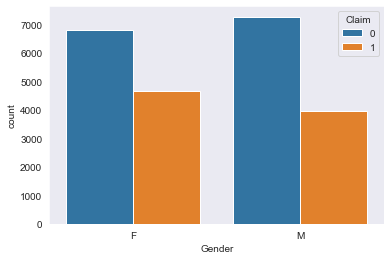

In [1210]:
sns.countplot(x=df_train['Gender'],hue=df_train['Claim'])

### Inference:
#####  distribution between Male & Females are moreover same
#####  No varaince is there
##### 60% Missing values 

### PreProcessing the Data

##### Dropping the ID & Gender columns

##### OHE on Agency Type & Distribution Channel

##### Imputed Categorical columns : Agency, Destination & Product Name with Probabilites

In [1211]:
df_train.drop(['ID','Gender'],axis=1, inplace=True)

In [1212]:
df_train.columns

Index(['Age', 'Agency', 'Agency Type', 'Commision (in value)', 'Destination',
       'Distribution Channel', 'Duration', 'Net Sales', 'Product Name',
       'Claim'],
      dtype='object')

In [1213]:
df_train['Destination'].value_counts().sum()

62288

In [1214]:
#Convert categorical to int

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62288 entries, 0 to 62287
Data columns (total 10 columns):
Age                     62288 non-null int64
Agency                  62288 non-null object
Agency Type             62288 non-null object
Commision (in value)    62288 non-null float64
Destination             62288 non-null object
Distribution Channel    62288 non-null object
Duration                62288 non-null int64
Net Sales               62288 non-null float64
Product Name            62288 non-null object
Claim                   62288 non-null int64
dtypes: float64(2), int64(3), object(5)
memory usage: 4.8+ MB


In [1215]:
df_train['Destination'] = pd.factorize(df_train['Destination'])[0] 

In [1216]:
df_destination = df_train['Destination']

In [1217]:
 df_train_dummies = pd.get_dummies(df_train)

In [1218]:
df_train_dummies.shape

(62288, 51)

In [1219]:
train=df_train_dummies.drop('Claim',axis=1)
target=df_train_dummies['Claim']

In [1220]:
train.shape

(62288, 50)

## Split the data in Training and testing

In [1221]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size = 0.2, random_state=0)

In [1222]:
y_test

35788    0
56447    0
54551    1
53995    0
61486    1
        ..
17693    0
45932    0
3719     1
51205    0
13567    0
Name: Claim, Length: 12458, dtype: int64

## Baseline Models

##### Random Forest

In [1223]:
from sklearn.ensemble import RandomForestClassifier
RF_model  = RandomForestClassifier()
RF_model.fit(X_train, y_train)
model_predictions = RF_model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

Accuracy:  0.9902070958420293
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      9870
           1       0.95      1.00      0.98      2588

    accuracy                           0.99     12458
   macro avg       0.98      0.99      0.99     12458
weighted avg       0.99      0.99      0.99     12458



##### Logistic Regression

In [1224]:
model = LogisticRegression()
model.fit(X_train, y_train)
model_predictions = model.predict(X_test)
print("Accuracy score: {}".format(accuracy_score(y_test, model_predictions)))
print("="*80)
print(classification_report(y_test, model_predictions))

Accuracy score: 0.8284636378230855
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      9870
           1       0.63      0.43      0.51      2588

    accuracy                           0.83     12458
   macro avg       0.74      0.68      0.70     12458
weighted avg       0.81      0.83      0.82     12458



C:\Users\Priyanka\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


##### Linear Discriminant  Analysis

In [1225]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)
model_predictions = model.predict(X_test)
print("Accuracy score: {}".format(accuracy_score(y_test, model_predictions)))
print("="*80)
print(classification_report(y_test, model_predictions))

Accuracy score: 0.823647455450313
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      9870
           1       0.57      0.61      0.59      2588

    accuracy                           0.82     12458
   macro avg       0.73      0.74      0.74     12458
weighted avg       0.83      0.82      0.83     12458



##### K-Neighbors

In [1226]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train, y_train)
model_predictions = model.predict(X_test)
print("Accuracy score: {}".format(accuracy_score(y_test, model_predictions)))
print("="*80)
print(classification_report(y_test, model_predictions))

Accuracy score: 0.9521592550971263
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      9870
           1       0.81      1.00      0.90      2588

    accuracy                           0.95     12458
   macro avg       0.91      0.97      0.93     12458
weighted avg       0.96      0.95      0.95     12458



##### Decision Tree

In [1227]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
model_predictions = model.predict(X_test)
print("Accuracy score: {}".format(accuracy_score(y_test, model_predictions)))
print("="*80)
print(classification_report(y_test, model_predictions))

Accuracy score: 0.9815379675710387
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      9870
           1       0.92      1.00      0.96      2588

    accuracy                           0.98     12458
   macro avg       0.96      0.99      0.97     12458
weighted avg       0.98      0.98      0.98     12458



##### GaussianNB

In [1228]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
model_predictions = model.predict(X_test)
print("Accuracy score: {}".format(accuracy_score(y_test, model_predictions)))
print("="*80)
print(classification_report(y_test, model_predictions))

Accuracy score: 0.8000481618237277
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      9870
           1       0.51      0.68      0.59      2588

    accuracy                           0.80     12458
   macro avg       0.71      0.76      0.73     12458
weighted avg       0.83      0.80      0.81     12458



#####  SVC

In [1229]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train, y_train)
model_predictions = model.predict(X_test)
print("Accuracy score: {}".format(accuracy_score(y_test, model_predictions)))
print("="*80)
print(classification_report(y_test, model_predictions))

Accuracy score: 0.8163429121849414
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      9870
           1       0.68      0.22      0.33      2588

    accuracy                           0.82     12458
   macro avg       0.75      0.59      0.61     12458
weighted avg       0.80      0.82      0.78     12458



In [1230]:
df1 = pd.read_csv('C:\\Users\\Priyanka\\Desktop\\python2\\Hackathon-1\\Data\\Test_file.csv')

In [1231]:
print('Test file:', df1.shape)

Test file: (15572, 11)


In [1232]:
df_test=df1.copy()

In [1233]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15572 entries, 0 to 15571
Data columns (total 11 columns):
ID                      15572 non-null int64
Age                     15572 non-null int64
Agency                  15572 non-null object
Agency Type             15572 non-null object
Commision (in value)    15572 non-null float64
Destination             15572 non-null object
Distribution Channel    15572 non-null object
Duration                15572 non-null int64
Gender                  5621 non-null object
Net Sales               15572 non-null float64
Product Name            15572 non-null object
dtypes: float64(2), int64(3), object(6)
memory usage: 1.3+ MB


In [1234]:
# Drop all  ID & Gender columns

df_test.drop(['ID','Gender'],axis=1, inplace=True)

In [1235]:
df_test_copy = df_test.copy

In [1236]:
df_test.columns

Index(['Age', 'Agency', 'Agency Type', 'Commision (in value)', 'Destination',
       'Distribution Channel', 'Duration', 'Net Sales', 'Product Name'],
      dtype='object')

In [1237]:
df_test['Destination'].value_counts().sum()

15572

In [1238]:
df_test['Destination'] = pd.factorize(df_test['Destination'])[0] 

In [1239]:
df_test_destination = df_test['Destination']

In [1240]:
df_test.drop(['Destination'],axis=1, inplace=True)

In [1241]:
df_test_dummies = pd.get_dummies(df_test)

In [1242]:
combined = pd.concat([df_test_destination,df_test_dummies], axis=1)

In [1243]:
combined.shape

(15572, 50)

In [1244]:
combined.shape

(15572, 50)

## Model Building   - I

#### Random forest

In [1245]:
target_test=df_train_dummies['Claim']

In [1246]:
target_test.shape

(62288,)

In [1247]:
combined.shape

(15572, 50)

In [1248]:
y_test.shape

(12458,)

In [1249]:
model_predictions1 = model.predict(combined)
print('Accuracy: ', accuracy_score(target_test[0:15572], model_predictions1))
#print(classification_report(y_test, model_predictions))

Accuracy:  0.7734395068070896


In [1250]:
print(classification_report(target_test[0:15572], model_predictions1))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87     12458
           1       0.20      0.04      0.07      3114

    accuracy                           0.77     15572
   macro avg       0.50      0.50      0.47     15572
weighted avg       0.68      0.77      0.71     15572



## preprocessing on train data

In [1251]:
#Imputing on Destination :
b=df_train['Destination'].value_counts()/df_train['Destination'].value_counts().sum()
b=b.to_dict()
df_train['Destination']= df_train['Destination'].map(b)

In [1252]:
#imputing on Product Name
c=df_train['Product Name'].value_counts()/df_train['Product Name'].value_counts().sum()
c=c.to_dict()
df_train['Product Name']= df_train['Product Name'].map(c)

In [1253]:
#Imputing on AGENCY
d=df_train['Agency'].value_counts()/df_train['Agency'].value_counts().sum()
d=d.to_dict()
df_train['Agency']= df_train['Agency'].map(d)

In [1254]:
claim2= pd.get_dummies(df_train)

In [1255]:
claim2.columns

Index(['Age', 'Agency', 'Commision (in value)', 'Destination', 'Duration',
       'Net Sales', 'Product Name', 'Claim', 'Agency Type_Airlines',
       'Agency Type_Travel Agency', 'Distribution Channel_Offline',
       'Distribution Channel_Online'],
      dtype='object')

In [1256]:
# all columns are in Numerical format:
claim2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62288 entries, 0 to 62287
Data columns (total 12 columns):
Age                             62288 non-null int64
Agency                          62288 non-null float64
Commision (in value)            62288 non-null float64
Destination                     62288 non-null float64
Duration                        62288 non-null int64
Net Sales                       62288 non-null float64
Product Name                    62288 non-null float64
Claim                           62288 non-null int64
Agency Type_Airlines            62288 non-null uint8
Agency Type_Travel Agency       62288 non-null uint8
Distribution Channel_Offline    62288 non-null uint8
Distribution Channel_Online     62288 non-null uint8
dtypes: float64(5), int64(3), uint8(4)
memory usage: 4.0 MB


### Baseline Model II
### splitting data into Train & Test

In [1257]:
X2=claim2.drop('Claim',axis=1)
y2=claim2['Claim']

In [1258]:
# Split data in to train and test

X_train, X_test, Y_train, Y_test = train_test_split(X2, y2, train_size=0.7, random_state=0)

### Random Forest

In [1306]:
from sklearn.ensemble import RandomForestClassifier
random_forest  = RandomForestClassifier()
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     14848
           1       0.95      1.00      0.97      3839

    accuracy                           0.99     18687
   macro avg       0.97      0.99      0.98     18687
weighted avg       0.99      0.99      0.99     18687



#### Logistic Regression

In [1260]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(accuracy_score(Y_test, Y_pred) * 100, 2)
prec_log= round(precision_score(Y_test, Y_pred) * 100, 2)
F1_log = round(f1_score(Y_test,Y_pred)*100,2)
Recall_log = round(recall_score(Y_test,Y_pred)*100,2)

C:\Users\Priyanka\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [1261]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89     14848
           1       0.66      0.25      0.36      3839

    accuracy                           0.82     18687
   macro avg       0.75      0.61      0.63     18687
weighted avg       0.80      0.82      0.79     18687



### Linear Discriminant Analysis 

In [1262]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA_model = LinearDiscriminantAnalysis()
LDA_model.fit(X_train, Y_train)
model_predictions = LDA_model.predict(X_test)
print("Accuracy score: {}".format(accuracy_score(Y_test, model_predictions)))
print("="*80)
print(classification_report(Y_test, model_predictions))

Accuracy score: 0.8220153047573179
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     14848
           1       0.65      0.29      0.40      3839

    accuracy                           0.82     18687
   macro avg       0.74      0.63      0.65     18687
weighted avg       0.80      0.82      0.79     18687



### K-Neighbors

In [1263]:
from sklearn.neighbors import KNeighborsClassifier
KN_model = KNeighborsClassifier()
KN_model.fit(X_train, Y_train)
model_predictions = KN_model.predict(X_test)
print("Accuracy score: {}".format(accuracy_score(Y_test, model_predictions)))
print("="*80)
print(classification_report(Y_test, model_predictions))

Accuracy score: 0.9477711778241559
              precision    recall  f1-score   support

           0       1.00      0.93      0.97     14848
           1       0.80      1.00      0.89      3839

    accuracy                           0.95     18687
   macro avg       0.90      0.97      0.93     18687
weighted avg       0.96      0.95      0.95     18687



### Decision Tree

In [1264]:
DC_model = DecisionTreeClassifier()
DC_model.fit(X_train, Y_train)
model_predictions = DC_model.predict(X_test)
print("Accuracy score: {}".format(accuracy_score(Y_test, model_predictions)))
print("="*80)
print(classification_report(Y_test, model_predictions))

Accuracy score: 0.9789693369722267
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     14848
           1       0.91      1.00      0.95      3839

    accuracy                           0.98     18687
   macro avg       0.95      0.99      0.97     18687
weighted avg       0.98      0.98      0.98     18687



### GaussianNB

In [1265]:
from sklearn.naive_bayes import GaussianNB
GB_model = GaussianNB()
GB_model.fit(X_train, Y_train)
model_predictions = GB_model.predict(X_test)
print("Accuracy score: {}".format(accuracy_score(Y_test, model_predictions)))
print("="*80)
print(classification_report(Y_test, model_predictions))

Accuracy score: 0.7838069245999894
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     14848
           1       0.48      0.65      0.55      3839

    accuracy                           0.78     18687
   macro avg       0.69      0.73      0.71     18687
weighted avg       0.81      0.78      0.79     18687



### SVC

In [1266]:
from sklearn.svm import SVC
SVC_model = SVC()
SVC_model.fit(X_train, Y_train)
model_predictions = SVC_model.predict(X_test)
print("Accuracy score: {}".format(accuracy_score(Y_test, model_predictions)))
print("="*80)
print(classification_report(Y_test, model_predictions))

Accuracy score: 0.8186974902338524
              precision    recall  f1-score   support

           0       0.83      0.97      0.90     14848
           1       0.68      0.22      0.33      3839

    accuracy                           0.82     18687
   macro avg       0.76      0.60      0.61     18687
weighted avg       0.80      0.82      0.78     18687



## Model bulding on test data   II

In [1267]:
df1 = pd.read_csv('C:\\Users\\Priyanka\\Desktop\\python2\\Hackathon-1\\Data\\Test_file.csv')

In [1268]:
df1.columns

Index(['ID', 'Age', 'Agency', 'Agency Type', 'Commision (in value)',
       'Destination', 'Distribution Channel', 'Duration', 'Gender',
       'Net Sales', 'Product Name'],
      dtype='object')

In [1269]:
df1.drop(['ID','Gender'],axis=1, inplace=True)

In [1270]:
#Imputing on Destination :
b=df1['Destination'].value_counts()/df1['Destination'].value_counts().sum()
b=b.to_dict()
df1['Destination']= df1['Destination'].map(b)

In [1271]:
c=df1['Product Name'].value_counts()/df1['Product Name'].value_counts().sum()
c=c.to_dict()
df1['Product Name']= df1['Product Name'].map(c)

In [1272]:
c=df1['Agency'].value_counts()/df1['Agency'].value_counts().sum()
c=c.to_dict()
df1['Agency']= df1['Agency'].map(c)

In [1273]:
claim_test= pd.get_dummies(df1)

In [1274]:
claim_test.shape

(15572, 11)

## Random Forest model

In [1307]:
Y_pred = random_forest.predict(claim_test)

In [1308]:
print('Accuracy: ', accuracy_score(target_test[0:15572], Y_pred))
print(classification_report(target_test[0:15572], Y_pred))

Accuracy:  0.6814795787310557
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     12458
           1       0.21      0.21      0.21      3114

    accuracy                           0.68     15572
   macro avg       0.50      0.50      0.50     15572
weighted avg       0.68      0.68      0.68     15572



In [1277]:
from imblearn.over_sampling import SMOTE

In [1278]:
oversampler = SMOTE(random_state = 0)
smote_train, smote_target = oversampler.fit_sample(X2, y2,)

C:\Users\Priyanka\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [1279]:
smote_train.shape

(99660, 11)

In [1280]:
X2.shape

(62288, 11)

### BASELINE MODELS WITH SMOTE TRAINING DATA


In [1281]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
smote_model  = RandomForestClassifier()
smote_model.fit(smote_train, smote_target)
smote_Y_pred = smote_model.predict(X_test)
print("Accuracy score: {}".format(accuracy_score(Y_test, smote_Y_pred)))
print("="*80)
print(classification_report(Y_test,smote_Y_pred))

Accuracy score: 0.997003264301386
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14848
           1       0.99      1.00      0.99      3839

    accuracy                           1.00     18687
   macro avg       0.99      1.00      1.00     18687
weighted avg       1.00      1.00      1.00     18687



In [1282]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(smote_train, smote_target)
Y_pred = logreg.predict(X_test)
print("Accuracy score: {}".format(accuracy_score(Y_test, Y_pred)))
print("="*80)
print(classification_report(Y_test,Y_pred))

Accuracy score: 0.7635789586343448
              precision    recall  f1-score   support

           0       0.90      0.79      0.84     14848
           1       0.45      0.66      0.53      3839

    accuracy                           0.76     18687
   macro avg       0.67      0.73      0.69     18687
weighted avg       0.81      0.76      0.78     18687



C:\Users\Priyanka\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [1283]:
# Linear Discriminant Analysis
LDA_model.fit(smote_train, smote_target)
model_predictions = LDA_model.predict(X_test)
print("Accuracy score: {}".format(accuracy_score(Y_test, model_predictions)))
print("="*80)
print(classification_report(Y_test, model_predictions))

Accuracy score: 0.7685021672820678
              precision    recall  f1-score   support

           0       0.90      0.80      0.85     14848
           1       0.46      0.65      0.54      3839

    accuracy                           0.77     18687
   macro avg       0.68      0.73      0.69     18687
weighted avg       0.81      0.77      0.78     18687



In [1284]:
# K-Neighbors
KN_model.fit(smote_train, smote_target)
model_predictions = KN_model.predict(X_test)
print("Accuracy score: {}".format(accuracy_score(Y_test, model_predictions)))
print("="*80)
print(classification_report(Y_test, model_predictions))

Accuracy score: 0.9720661422379194
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     14848
           1       0.88      1.00      0.94      3839

    accuracy                           0.97     18687
   macro avg       0.94      0.98      0.96     18687
weighted avg       0.98      0.97      0.97     18687



In [1285]:
# Decision Tree
DC_model.fit(smote_train, smote_target)
model_predictions = DC_model.predict(X_test)
print("Accuracy score: {}".format(accuracy_score(Y_test, model_predictions)))
print("="*80)
print(classification_report(Y_test, model_predictions))

Accuracy score: 0.997003264301386
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14848
           1       0.99      1.00      0.99      3839

    accuracy                           1.00     18687
   macro avg       0.99      1.00      1.00     18687
weighted avg       1.00      1.00      1.00     18687



In [1286]:
# GaussianNB
GB_model = GaussianNB()
GB_model.fit(smote_train, smote_target)
model_predictions = GB_model.predict(X_test)
print("Accuracy score: {}".format(accuracy_score(Y_test, model_predictions)))
print("="*80)
print(classification_report(Y_test, model_predictions))

Accuracy score: 0.7153636217691444
              precision    recall  f1-score   support

           0       0.90      0.72      0.80     14848
           1       0.39      0.69      0.50      3839

    accuracy                           0.72     18687
   macro avg       0.65      0.71      0.65     18687
weighted avg       0.80      0.72      0.74     18687



In [1287]:
# SVC
SVC_model = SVC()
SVC_model.fit(smote_train, smote_target)
model_predictions = SVC_model.predict(X_test)
print("Accuracy score: {}".format(accuracy_score(Y_test, model_predictions)))
print("="*80)
print(classification_report(Y_test, model_predictions))

Accuracy score: 0.7394445336330069
              precision    recall  f1-score   support

           0       0.90      0.76      0.82     14848
           1       0.42      0.67      0.51      3839

    accuracy                           0.74     18687
   macro avg       0.66      0.71      0.67     18687
weighted avg       0.80      0.74      0.76     18687



### Model Building with SMOTE

In [1289]:
## Random Forest model
smote_Y_pred = smote_model.predict(claim_test)

print(classification_report(target_test[0:15572],smote_Y_pred))
acc_RF = accuracy_score(target_test[0:15572],smote_Y_pred)

              precision    recall  f1-score   support

           0       0.80      0.81      0.80     12458
           1       0.21      0.20      0.21      3114

    accuracy                           0.69     15572
   macro avg       0.50      0.50      0.50     15572
weighted avg       0.68      0.69      0.68     15572



In [1290]:
# Logistic Regression
Y_pred = logreg.predict(claim_test)

print(classification_report(target_test[0:15572], Y_pred))
acc_LR = accuracy_score(target_test[0:15572], Y_pred)

              precision    recall  f1-score   support

           0       0.80      0.71      0.75     12458
           1       0.21      0.30      0.24      3114

    accuracy                           0.63     15572
   macro avg       0.50      0.51      0.50     15572
weighted avg       0.68      0.63      0.65     15572



In [1291]:
# Linear Discriminant Analysis
model_predictions = LDA_model.predict(claim_test)

print(classification_report(target_test[0:15572], model_predictions))
acc_LDA = accuracy_score(target_test[0:15572], model_predictions)

              precision    recall  f1-score   support

           0       0.80      0.72      0.76     12458
           1       0.20      0.29      0.24      3114

    accuracy                           0.63     15572
   macro avg       0.50      0.50      0.50     15572
weighted avg       0.68      0.63      0.65     15572



In [1292]:
# K-Neighbors
model_predictions = KN_model.predict(claim_test)

print(classification_report(target_test[0:15572], model_predictions))
acc_KN = accuracy_score(target_test[0:15572], model_predictions)

              precision    recall  f1-score   support

           0       0.80      0.76      0.78     12458
           1       0.20      0.24      0.22      3114

    accuracy                           0.66     15572
   macro avg       0.50      0.50      0.50     15572
weighted avg       0.68      0.66      0.67     15572



In [1293]:
# Decision Tree
model_predictions = DC_model.predict(claim_test)

print(classification_report(target_test[0:15572], model_predictions))
acc_DC = accuracy_score(target_test[0:15572], model_predictions)

              precision    recall  f1-score   support

           0       0.80      0.80      0.80     12458
           1       0.20      0.21      0.20      3114

    accuracy                           0.68     15572
   macro avg       0.50      0.50      0.50     15572
weighted avg       0.68      0.68      0.68     15572



In [1295]:
# GaussianNB
model_predictions = GB_model.predict(claim_test)
acc_GB = accuracy_score(target_test[0:15572], model_predictions)
print(classification_report(target_test[0:15572], model_predictions))

              precision    recall  f1-score   support

           0       0.80      0.65      0.72     12458
           1       0.20      0.36      0.26      3114

    accuracy                           0.59     15572
   macro avg       0.50      0.50      0.49     15572
weighted avg       0.68      0.59      0.62     15572



In [1296]:
# SVC

model_predictions = SVC_model.predict(claim_test)
acc_SVC = accuracy_score(target_test[0:15572], model_predictions)
print(classification_report(target_test[0:15572], model_predictions))

              precision    recall  f1-score   support

           0       0.80      0.68      0.74     12458
           1       0.20      0.32      0.25      3114

    accuracy                           0.61     15572
   macro avg       0.50      0.50      0.49     15572
weighted avg       0.68      0.61      0.64     15572



### Which is the best Model ?

In [1299]:
results = pd.DataFrame({
    'Model': ['Random Forest','Logistic Regression','LDA', 'KNN','Decision Tree', 'GB','Support Vector Machines'],
    'Score': [acc_RF, acc_LR,acc_LDA, acc_KN ,acc_DC, acc_GB, acc_SVC]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df

,Model
Score,
0.685397,Random Forest
0.679489,Decision Tree
0.657655,KNN
0.631069,LDA
0.629527,Logistic Regression
0.608849,Support Vector Machines
0.589584,GB


## K-Fold Cross Validation:

In [1304]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")

In [1301]:
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.99367851 0.9931768  0.99367851 0.9943809  0.99407987 0.99387919
 0.99548465 0.99428055 0.99377885 0.99448124]
Mean: 0.9940899056793097
Standard Deviation: 0.0005943890515600944


In [1302]:
## Feature Importance

In [1309]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

In [1313]:
X_train.columns

Index(['Age', 'Agency', 'Commision (in value)', 'Destination', 'Duration',
       'Net Sales', 'Product Name', 'Agency Type_Airlines',
       'Agency Type_Travel Agency', 'Distribution Channel_Offline',
       'Distribution Channel_Online'],
      dtype='object')

In [1311]:
importances.head(15)

,importance
feature,
Duration,0.269
Age,0.192
Net Sales,0.173
Destination,0.142
Commision (in value),0.096
Agency,0.042
Product Name,0.035
Agency Type_Travel Agency,0.024
Agency Type_Airlines,0.023


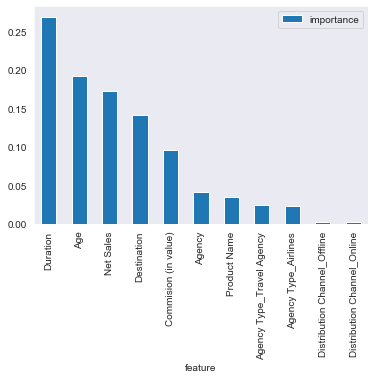

In [1314]:
importances.plot.bar();

## Conclusion:

In [1317]:
claim2  = claim2.drop(["Distribution Channel_Offline", "Distribution Channel_Online"], axis=1, inplace=True)
claim_test  = claim_test.drop(["Distribution Channel_Offline", "Distribution Channel_Online"], axis=1, inplace=True)

## Training random forest again:

In [1318]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

99.72 %


In [1319]:
print("out of bag score:", round(random_forest.oob_score_, 4)*100, "%")

out of bag score: 98.79 %


## Hyperparameter Tuning

In [1320]:
param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}

from sklearn.model_selection import GridSearchCV, cross_val_score

rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)

clf.fit(X_train, Y_train)

clf.bestparams

C:\Users\Priyanka\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Priyanka\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1320-960564e8410a>", line 11, in <module>
    clf.bestparams
AttributeError: 'GridSearchCV' object has no attribute 'bestparams'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Priyanka\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Priyanka\Anaconda3\lib\site-packages\tensorflow_core\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\Users\Priy

AttributeError: 'GridSearchCV' object has no attribute 'bestparams'

### Test new paramters:

In [1321]:
# Random Forest
random_forest = RandomForestClassifier(criterion = "gini", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 10,   
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)

random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

oob score: 98.37 %


### Further Evaluation

### Confusion Matrix:

In [1322]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(random_forest, X_train, Y_train, cv=3)
confusion_matrix(Y_train, predictions)

array([[34159,   823],
       [  421,  8198]], dtype=int64)

## Precision and Recall:

In [1323]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(Y_train, predictions))
print("Recall:",recall_score(Y_train, predictions))

Precision: 0.9087684292207072
Recall: 0.9511544262675484


## F-Score

In [1324]:
from sklearn.metrics import f1_score
f1_score(Y_train, predictions)

0.9294784580498866

## Precision Recall Curve

In [1325]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = random_forest.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(Y_train, y_scores)

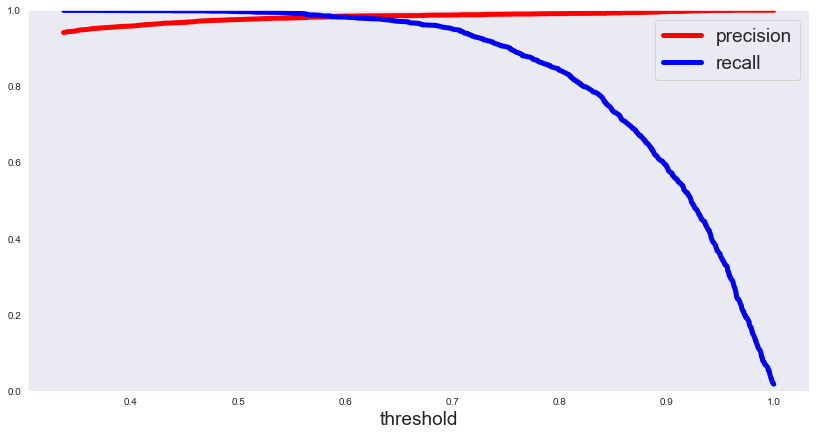

In [1326]:
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()


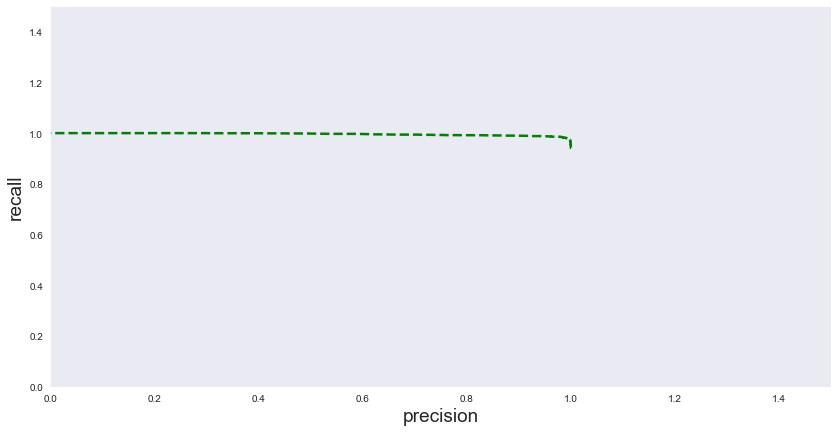

In [1327]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(precision, recall)
plt.show()


## ROC AUC Curve

In [1331]:
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, y_scores)

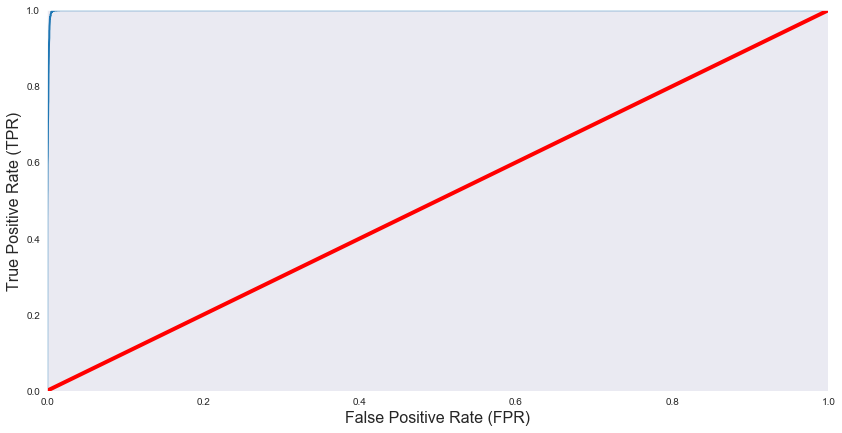

In [1332]:
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

### ROC AUC Curve

In [1333]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(Y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.9992037789358119


### Submission

In [1334]:
df2 = pd.read_csv('C:\\Users\\Priyanka\\Desktop\\python2\\Hackathon-1\\Data\\Test_file.csv')

In [1337]:
submission = pd.DataFrame({
        "Customer Id":df2["ID"],
        "Claim":  Y_pred})
submission.to_csv('submission.csv', index=False)

In [1338]:
df_submission = pd.read_csv('submission.csv')

In [1339]:
df_submission

,Customer Id,Claim
0,26611,0
1,50772,1
2,59472,0
3,5466,0
4,61014,1
...,...,...
15567,34914,1
15568,27464,1
15569,57687,0
15570,57158,1
